In [150]:
import time
import json
import pandas as pd
import concurrent.futures
from openai import AzureOpenAI
import os
from dotenv import load_dotenv
import random
from typing import List, Dict, Tuple
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np

In [151]:
import os
import openai
from dotenv import load_dotenv

def test_azure_connection():
    """
    A minimal script to test the connection and credentials for Azure OpenAI.
    """
    print("Attempting to connect to Azure OpenAI...")
    
    # 1. Load credentials from .env file
    load_dotenv()

    try:
        # 2. Configure the Azure OpenAI client
        AZURE_ENDPOINT = os.environ.get("AZURE_OPENAI_ENDPOINT")
        AZURE_API_KEY = os.environ.get("AZURE_OPENAI_KEY")
        AZURE_API_VERSION = "2024-02-01"
        
        # IMPORTANT: Change this to your deployment name
        AZURE_DEPLOYMENT_NAME = "your_deployment_name_here"

        if not all([AZURE_ENDPOINT, AZURE_API_KEY, AZURE_DEPLOYMENT_NAME]):
            print("❌ ERROR: Required environment variables are not set. Check your .env file.")
            return

        client = openai.AzureOpenAI(
            azure_endpoint=AZURE_ENDPOINT,
            api_key=AZURE_API_KEY,
            api_version=AZURE_API_VERSION,
        )

        # 3. Make a simple test API call
        print(f"Sending a test request to deployment: '{AZURE_DEPLOYMENT_NAME}'...")
        
        response = client.chat.completions.create(
            model=AZURE_DEPLOYMENT_NAME,
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": "Does this connection work?"},
            ],
            max_tokens=20
        )

        print("\n✅ SUCCESS! Connection established and received a response.")
        print("Model Response:", response.choices[0].message.content)

    except openai.APIConnectionError as e:
        print("\n❌ CONNECTION ERROR: The script could not connect to the Azure endpoint.")
        print("This is likely a network, firewall, or incorrect endpoint issue.")
        print(f"Error Details: {e.__cause__}")
        
    except openai.AuthenticationError as e:
        print(f"\n❌ AUTHENTICATION ERROR (Code: {e.status_code}): Access denied.")
        print("This means your API Key is incorrect or has expired.")
        
    except openai.NotFoundError as e:
        print(f"\n❌ NOT FOUND ERROR (Code: {e.status_code}): The resource was not found.")
        print("This usually means your Deployment Name is incorrect.")

    except Exception as e:
        print(f"\n❌ An unexpected error occurred: {e}")


if __name__ == "__main__":
    test_azure_connection()

Attempting to connect to Azure OpenAI...
Sending a test request to deployment: 'your_deployment_name_here'...

✅ SUCCESS! Connection established and received a response.
Model Response: I can’t test physical connections, but I’m here to help troubleshoot! If you’re having issues


In [152]:
# --- 1. CONFIGURATION (FOR AZURE OPENAI WITH .env FILE) ---
from dotenv import load_dotenv # Import the library

load_dotenv() # Load variables from your .env file

# It's best practice to set your Azure credentials as environment variables.
# Your team will provide you with these values.
try:
    AZURE_ENDPOINT = os.environ.get("AZURE_OPENAI_ENDPOINT")
    AZURE_API_KEY = os.environ.get("AZURE_OPENAI_KEY")
    AZURE_API_VERSION = "2024-02-01" # Use the API version recommended for your endpoint
    
    # This is the name of your specific deployment on Azure, NOT the model name like "gpt-4o".
    AZURE_DEPLOYMENT_NAME = "hy" # <--- CHANGE THIS

    if not all([AZURE_ENDPOINT, AZURE_API_KEY, AZURE_DEPLOYMENT_NAME]):
        raise ValueError("Azure environment variables not set. Make sure they are in your .env file.")

    # Instantiate the client using Azure-specific credentials
    client = openai.AzureOpenAI(
        azure_endpoint=AZURE_ENDPOINT,
        api_key=AZURE_API_KEY,
        api_version=AZURE_API_VERSION,
    )
    
    # The MODEL variable now refers to your deployment name for use in the rest of the script
    MODEL = AZURE_DEPLOYMENT_NAME
    
    print("Azure OpenAI client configured successfully from .env file.")

except (ValueError, openai.OpenAIError) as e:
    print("Azure OpenAI configuration failed. Please check your .env file and deployment name.")
    print(f"Error: {e}")
    exit()

Azure OpenAI client configured successfully from .env file.


In [153]:
df=pd.read_csv("C:\\media-screener\\media-screener_LLM\\APEON\\GEPA\\Espionage_cases_by_model.csv")
df.head()

,Filename,Title,Max_Similarity,Trigger_Keyword,Full_Text,Truth
0,news_room/date=20250705/hour=00/I00ae9be059341...,I'm human. Are you? The battle for our online ...,0.5412,cyber espionage,It's every manager's worst nightmare: hiring a...,Espionage
1,news_room/date=20250705/hour=00/I00bf3db059341...,Firms urged to think like cyber criminals to b...,0.5059,national security,Organisations need to think like cyber crimina...,Nonespionage
2,news_room/date=20250705/hour=00/I0210eb0059341...,I'm human. Are you? The quest for our online i...,0.5318,cyber espionage,It's every manager's worst nightmare: Hiring a...,Espionage
3,news_room/date=20250705/hour=00/I2839746059381...,"IRGC kills one woman, wounds 12 in Iran while ...",0.5375,spies,The report from the Islamic Republic-backed ne...,Espionage
4,news_room/date=20250705/hour=00/Id2e51ff059371...,Cochise County adds drones to border enforceme...,0.5662,surveillance drone,"The Cochise Sheriff's Department is adding a ""...",Nonespionage


In [165]:
# initial_prompt = """
# Analyze the given article and determine if it relates to espionage activities.

# Espionage indicators include:
# - Intelligence gathering activities
# - Spying operations or spy networks
# - Classified information theft or leaks
# - Foreign intelligence services
# - Covert operations
# - Surveillance activities by intelligence agencies
# - Recruitment of assets or informants
# - Counterintelligence operations

# NOT espionage (common false positives):
# - General cybersecurity incidents
# - Regular diplomatic activities
# - Public policy discussions about intelligence
# - Historical references without current operations
# - General national security topics

# Provide your analysis in JSON format with:
# - "is_espionage": boolean (true if article is about espionage)
# - "confidence": float between 0.0 and 1.0
# - "reasoning": string explaining your decision

# Example:
# {{"is_espionage": true, "confidence": 0.85, "reasoning": "Article describes recruitment of intelligence assets and covert information gathering operations"}}

# ---
# News Article:
# {news_article_text}
# """

initial_prompt=""" Analyze the given article to determine if it directly involves active espionage operations or current intelligence agency involvement. Focus on identifying explicit evidence and credible indicators of ongoing covert activities, ensuring that any claims of espionage are substantiated by clear evidence or credible indicators linked to intelligence activities. Include consideration of potential espionage indicators even within legislative hearings or policy discussions if they involve credible signs of active intelligence gathering or covert operations.

Espionage indicators include:
- Ongoing intelligence gathering activities explicitly linked to current espionage operations
- Active spying operations or spy networks with recent documented evidence or credible circumstantial indicators
- Recent classified information theft or leaks involving foreign entities or intelligence agencies
- Current involvement of foreign intelligence services, supported by clear evidence or credible indicators
- Ongoing covert operations with evidence or credible indicators of infiltration under false pretenses
- Recent surveillance activities directly linked to intelligence agencies or with credible signs of such links
- Current recruitment of assets or informants for intelligence purposes with documented or credible circumstantial evidence
- Recent counterintelligence operations with clear evidence or credible indicators of espionage activities
- Legislative actions or laws addressing current espionage threats, especially if they involve credible indicators of active espionage, such as unauthorized incursions or potential exploitation of foreign-manufactured technology
- Recent state-backed cyberattacks with intelligence motives and documented or credible circumstantial evidence
- Use of foreign-manufactured technology with confirmed or credibly suggested links to current espionage activities

NOT espionage (common false positives):
- General cybersecurity incidents without intelligence links
- Secretive government actions without espionage motives or credible indicators
- Military or intelligence personnel involvement without espionage evidence or credible indicators
- Regular diplomatic activities
- Public policy discussions or critiques without operational context or credible indicators, unless they identify specific espionage threats
- Historical references without links to current espionage activities
- General national security topics without direct espionage evidence or credible indicators
- Presence of foreign entities without espionage evidence or credible indicators
- Data breaches without evidence or credible indicators linking to intelligence activities
- Legislative discussions without evidence or credible indicators of actual espionage operations, unless they highlight specific espionage threats

Provide your analysis in JSON format with:
- "is_espionage" : boolean (true if article is about espionage)
- "confidence": float between 0.0 and 1.0
- "reasoning": string explaining your decision

Example:
{{"is_espionage": true, "confidence": 0.85, "reasoning": "Article describes recruitment of intelligence assets and ongoing covert information gathering operations, linking to recent espionage activities."}}

---
News Article:
{news_article_text}
"""

## 4. Core GEPA Functions

These three functions form the engine of our optimizer:
1.  `run_prediction`: Executes the prompt and parses the JSON output.
2.  `generate_feedback`: Reflects on an error to understand why it happened.
3.  `update_prompt`: Rewrites the prompt based on the feedback to prevent future errors.

In [166]:
# Replace the code in your "Core GEPA Functions" cell (currently Cell 7)

def run_prediction(text: str, prompt_template: str) -> dict:
    """
    Runs the classification task with the new prompt and returns the parsed JSON.
    Returns a default "Nonespionage" dictionary on error.
    """
    prompt = prompt_template.format(news_article_text=text)
    default_response = {"is_espionage": False, "confidence": 0.0, "reasoning": "Error during prediction."}
    
    try:
        response = client.chat.completions.create(
            model=MODEL,
            response_format={"type": "json_object"},
            messages=[
                {"role": "system", "content": "You are an intelligence analyst that only outputs valid JSON based on the user's specified format."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.0,
            max_tokens=512 # Can be smaller for this simpler JSON
        )
        response_text = response.choices[0].message.content
        try:
            return json.loads(response_text)
        except (json.JSONDecodeError, TypeError):
            print("   -> Warning: LLM returned malformed JSON.")
            return default_response
    except Exception as e:
        print(f"An API error occurred: {e}")
        time.sleep(5)
        return default_response

# The feedback and update functions are fine, but this updated feedback function is slightly better
def generate_feedback(text: str, current_prompt: str, prediction_json: dict, ground_truth: str) -> str:
    """Reflects on an error to generate a textual reason for the failure."""
    inferred_label = 'Espionage' if prediction_json.get('is_espionage') else 'Nonespionage'
    feedback_meta_prompt = f"""
    An LLM using the 'Current Prompt' failed to correctly classify the 'Input Text'. The prediction was wrong. Provide a concise, one-sentence explanation for the failure based on the model's reasoning.

    - Current Prompt: "{current_prompt}"
    - Input Text: "{text}"
    - LLM's full JSON Output: "{json.dumps(prediction_json, indent=2)}"
    - My Incorrect Inferred Label: "{inferred_label}"
    - Correct Answer: "{ground_truth}"

    Reason for error:
    """
    try:
        response = client.chat.completions.create(
            model=MODEL,
            messages=[{"role": "user", "content": feedback_meta_prompt}],
            temperature=0.5
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"An API error occurred during feedback generation: {e}")
        return "Could not generate feedback due to API error."

def update_prompt(current_prompt: str, feedback: str, text: str) -> str:
    """Evolves the prompt based on the feedback from the last error."""
    update_meta_prompt = f"""
    You are a prompt engineering expert. Your task is to refine the 'Current Prompt' to prevent a specific error.
    The prompt led to an error, explained in the 'Feedback on Error'.
    Your task is to rewrite the entire prompt, incorporating a targeted change to fix the error.

    **RULES FOR YOUR RESPONSE:**
    1.  Your output MUST be only the complete, raw text of the new prompt.
    2.  DO NOT include any explanations, introductions, or conversational text like "Certainly!" or "Here is the updated prompt:".
    3.  DO NOT wrap your response in markdown fences (```) or any other formatting.
    4.  Your response should be immediately usable as the next prompt in an automated system.

    ---
    Current Prompt:
    {current_prompt}
    ---
    Feedback on Error: 
    "{feedback}"
    ---
    New, improved prompt:
    """
    try:
        response = client.chat.completions.create(
            model=MODEL,
            messages=[{"role": "user", "content": update_meta_prompt}],
            temperature=0.5,
        )
        clean_prompt = response.choices[0].message.content.strip()
        return clean_prompt
    
    except Exception as e:
        print(f"An API error occurred during prompt update: {e}")
        return current_prompt



## 5. Optimization Loop

This is the main execution block. It iterates through the dataset (or a slice of it), runs the prediction, and triggers the feedback/update cycle if an error occurs. All results are stored for final evaluation.

In [169]:
# Replace the code in your "Optimization Loop" cell (currently Cell 9)

print("\n--- Starting GEPA Optimization Loop ---\n")

current_prompt = initial_prompt
prompt_history = [{'row_index': -1, 'prompt': initial_prompt, 'status': 'Initial'}]
y_true = []
y_pred = []

# To run on the full dataset, remove the [:20] slice if you have it
for index, row in df.iterrows():
    text = row['Full_Text']
    ground_truth = row['Truth']

    if pd.isna(text) or pd.isna(ground_truth):
        print(f"Row {index}: Skipping due to missing data.")
        continue

    prediction_json = run_prediction(text, current_prompt)
    
    # *** THIS IS THE CORRECTED LOGIC ***
    # Infer the prediction directly from the "is_espionage" boolean key.
    is_espionage_prediction = prediction_json.get('is_espionage', False)
    inferred_prediction = "Espionage" if is_espionage_prediction else "Nonespionage"

    y_true.append(ground_truth)
    y_pred.append(inferred_prediction)

    if inferred_prediction == ground_truth:
        print(f"✅ Row {index}: Correct ('{inferred_prediction}').")
    else:
        print(f"❌ Row {index}: Incorrect. Predicted '{inferred_prediction}', was '{ground_truth}'.")
        print("   -> Generating feedback...")
        feedback = generate_feedback(text, current_prompt, prediction_json, ground_truth)
        print(f"   -> Feedback received: {feedback}")
        print("   -> Updating prompt...")
        new_prompt = update_prompt(current_prompt, feedback, text)
        current_prompt = new_prompt
        prompt_history.append({'row_index': index, 'prompt': new_prompt, 'status': f'Updated after error on Row {index}'})
        print(f"   -> Prompt has evolved.")

print("\n--- Optimization Loop Finished ---\n")


--- Starting GEPA Optimization Loop ---

✅ Row 0: Correct ('Espionage').
✅ Row 1: Correct ('Nonespionage').
✅ Row 2: Correct ('Espionage').
✅ Row 3: Correct ('Espionage').
✅ Row 4: Correct ('Nonespionage').
✅ Row 5: Correct ('Nonespionage').
✅ Row 6: Correct ('Nonespionage').
✅ Row 7: Correct ('Nonespionage').
✅ Row 8: Correct ('Nonespionage').
✅ Row 9: Correct ('Nonespionage').
✅ Row 10: Correct ('Nonespionage').
✅ Row 11: Correct ('Nonespionage').
✅ Row 12: Correct ('Nonespionage').
✅ Row 13: Correct ('Nonespionage').
✅ Row 14: Correct ('Nonespionage').
✅ Row 15: Correct ('Nonespionage').
✅ Row 16: Correct ('Nonespionage').
✅ Row 17: Correct ('Nonespionage').
✅ Row 18: Correct ('Nonespionage').
✅ Row 19: Correct ('Nonespionage').
✅ Row 20: Correct ('Nonespionage').
✅ Row 21: Correct ('Nonespionage').
✅ Row 22: Correct ('Nonespionage').
✅ Row 23: Correct ('Nonespionage').
✅ Row 24: Correct ('Nonespionage').
✅ Row 25: Correct ('Nonespionage').
✅ Row 26: Correct ('Nonespionage').
✅ Row

In [170]:
print("\n--- Final Performance Metrics ---\n")
print(classification_report(y_true, y_pred, zero_division=0))


--- Final Performance Metrics ---

              precision    recall  f1-score   support

   Espionage       0.86      0.83      0.85        36
Nonespionage       0.99      0.99      0.99       448

    accuracy                           0.98       484
   macro avg       0.92      0.91      0.92       484
weighted avg       0.98      0.98      0.98       484



In [171]:
print("\n--- Prompt Evolution History ---\n")
for item in prompt_history:
    print("="*50)
    print(f"Status: {item['status']}")
    print("="*50)
    print(item['prompt'])
    print("\n")


--- Prompt Evolution History ---

Status: Initial
 Analyze the given article to determine if it directly involves active espionage operations or current intelligence agency involvement. Focus on identifying explicit evidence and credible indicators of ongoing covert activities, ensuring that any claims of espionage are substantiated by clear evidence or credible indicators linked to intelligence activities. Include consideration of potential espionage indicators even within legislative hearings or policy discussions if they involve credible signs of active intelligence gathering or covert operations.

Espionage indicators include:
- Ongoing intelligence gathering activities explicitly linked to current espionage operations
- Active spying operations or spy networks with recent documented evidence or credible circumstantial indicators
- Recent classified information theft or leaks involving foreign entities or intelligence agencies
- Current involvement of foreign intelligence services

In [172]:
# Add this as a new cell at the end of your notebook

import json

# Define a filename for your output
output_filename = "prompt_evolution_history.json"

# Write the prompt_history list to the new file
try:
    with open(output_filename, 'w', encoding='utf-8') as f:
        # json.dump() converts the Python list of dictionaries into a JSON string
        # indent=4 makes the file nicely formatted and human-readable
        json.dump(prompt_history, f, ensure_ascii=False, indent=4)
    
    print(f"\n✅ Successfully saved the prompt history to: {output_filename}")

except Exception as e:
    print(f"\n❌ Error saving file: {e}")


✅ Successfully saved the prompt history to: prompt_evolution_history.json


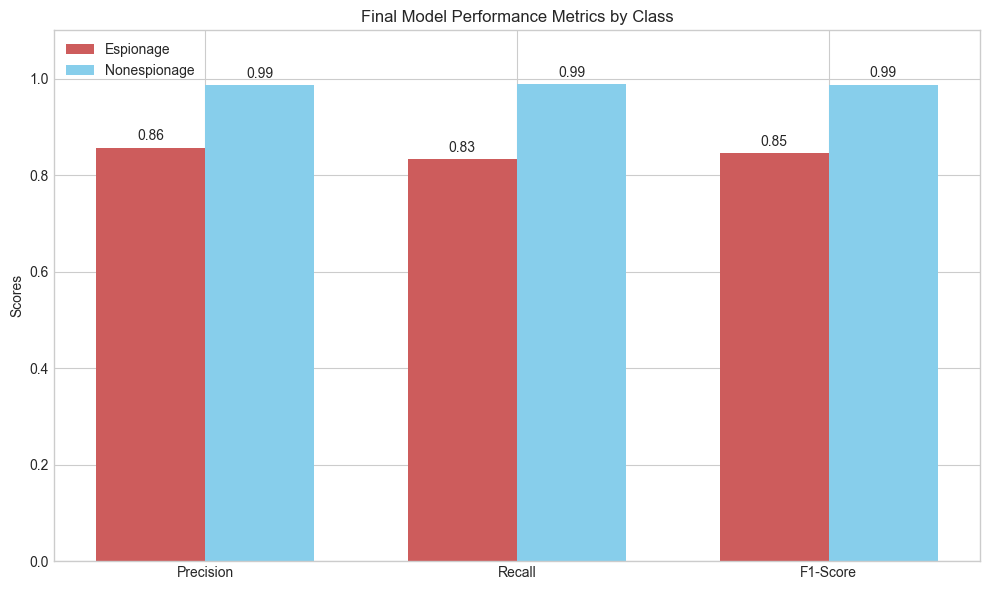


Chart saved as 'final_performance_metrics.png'


In [174]:
# --- Rerun the classification report to get the final numbers ---
# Note: y_true and y_pred are from the blended results of the optimization loop.
# For a pure test of the final prompt, you would use the "Two-Pass" method described previously.
report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

# Extract metrics from the report
labels = ['Precision', 'Recall', 'F1-Score']
espionage_metrics = [
    report['Espionage']['precision'],
    report['Espionage']['recall'],
    report['Espionage']['f1-score']
]
nonespionage_metrics = [
    report['Nonespionage']['precision'],
    report['Nonespionage']['recall'],
    report['Nonespionage']['f1-score']
]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, espionage_metrics, width, label='Espionage', color='indianred')
rects2 = ax.bar(x + width/2, nonespionage_metrics, width, label='Nonespionage', color='skyblue')

# Add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Final Model Performance Metrics by Class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.1)
ax.legend()

ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')

fig.tight_layout()

# Save the figure to a file
plt.savefig('final_performance_metrics.png')

plt.show()

print("\nChart saved as 'final_performance_metrics.png'")